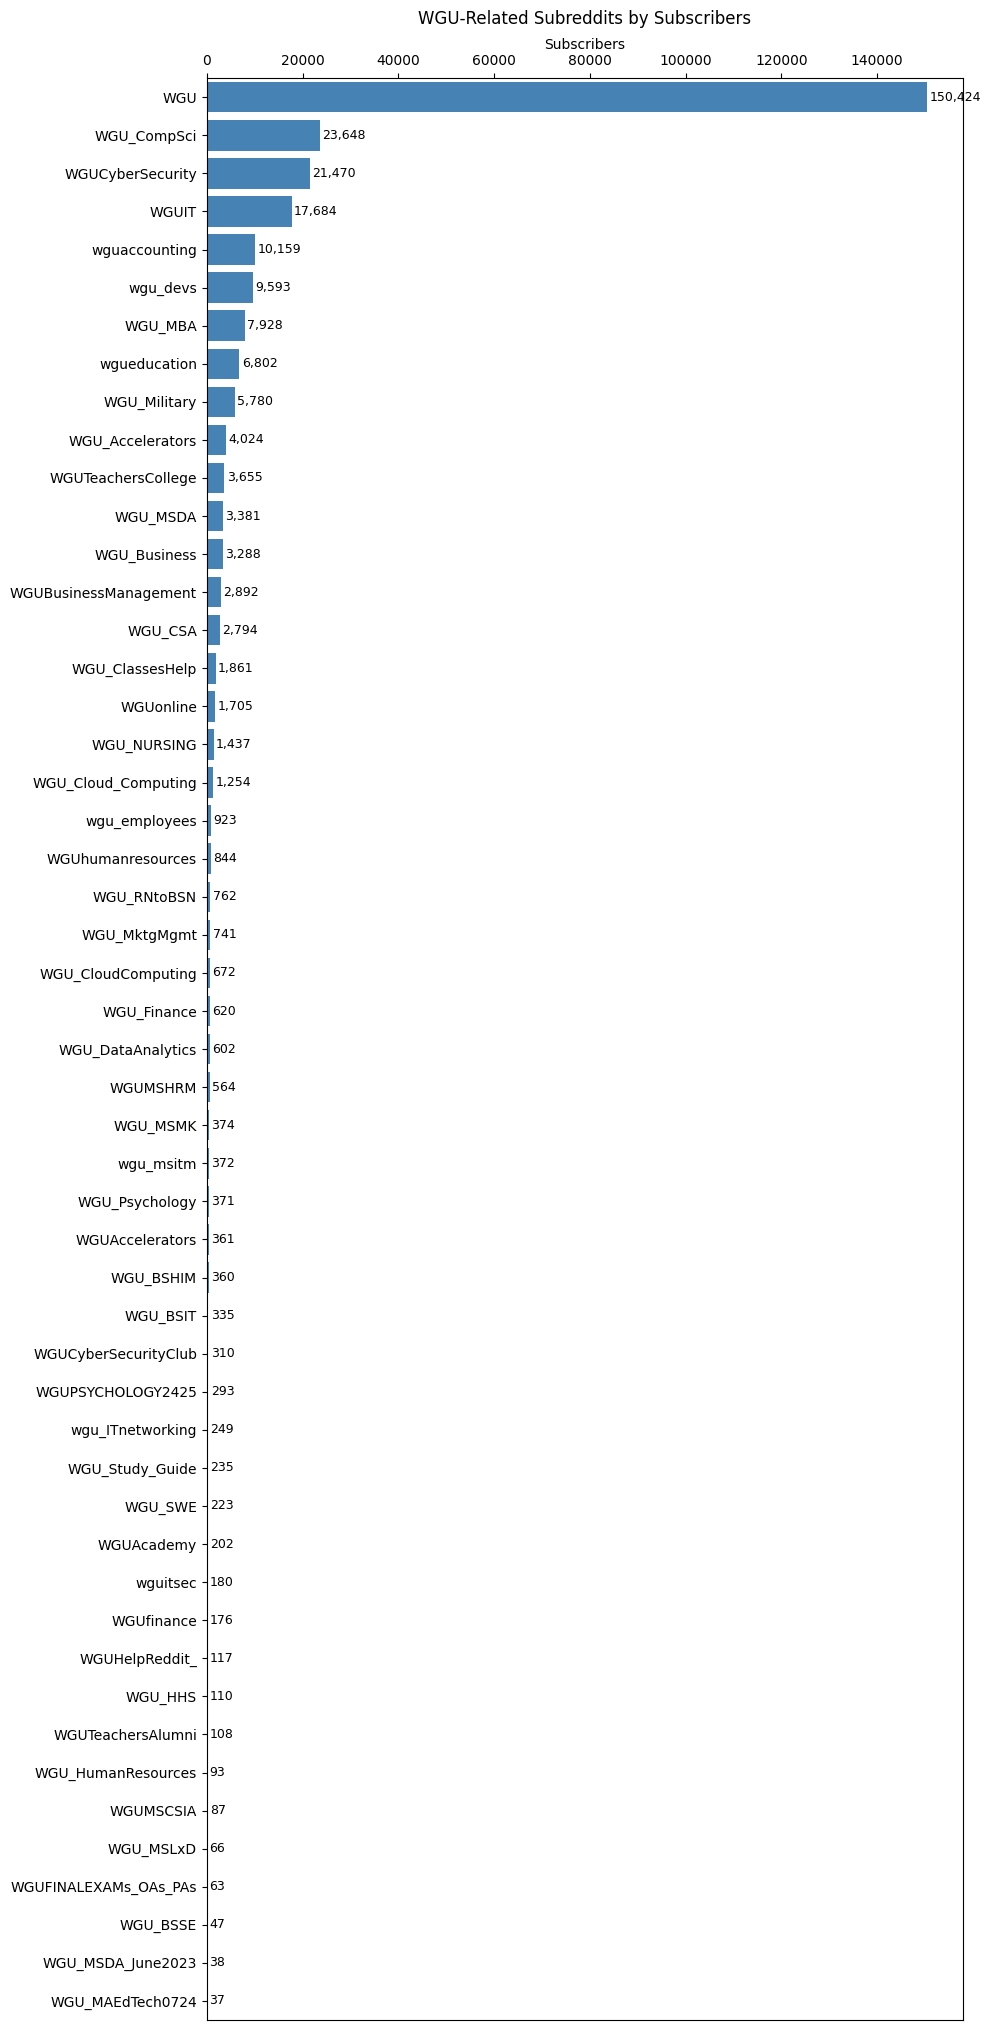

In [1]:
# filename: notebooks/plot_wgu_subs_scrollable.py

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# === Load current subscriber data ===
conn = sqlite3.connect("/Users/buddy/Desktop/WGU-Reddit/db/WGU-Reddit.db")
query = """
WITH latest_snapshot AS (
  SELECT subreddit_id, MAX(captured_at) AS last_ts
  FROM subreddit_stats
  GROUP BY subreddit_id
),
current_subs AS (
  SELECT ss.subreddit_id, ss.subscriber_count
  FROM subreddit_stats ss
  JOIN latest_snapshot ls ON ss.subreddit_id = ls.subreddit_id AND ss.captured_at = ls.last_ts
)
SELECT s.name, c.subscriber_count
FROM current_subs c
JOIN subreddits s ON c.subreddit_id = s.subreddit_id
ORDER BY c.subscriber_count DESC
"""
df = pd.read_sql_query(query, conn)
conn.close()

# === Sort for horizontal bar chart ===
df = df.sort_values('subscriber_count', ascending=True)

# === Plot ===
fig, ax = plt.subplots(figsize=(10, 0.4 * len(df)))

bars = ax.barh(df['name'], df['subscriber_count'], color='steelblue')

# Add labels at end of bars
for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(width + 500, y, f"{int(width):,}", va='center', fontsize=9)

ax.set_xlabel("Subscribers")
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_title("WGU-Related Subreddits by Subscribers", pad=10)

# Minimize vertical padding
ax.margins(y=0.01)
ax.set_ylim(-0.5, len(df) - 0.5)

plt.tight_layout()
plt.show()

In [2]:
# === Subreddit Growth Table ===
conn = sqlite3.connect("/Users/buddy/Desktop/WGU-Reddit/db/WGU-Reddit.db")
query = """
WITH first_last AS (
  SELECT subreddit_id, MIN(captured_at) AS first_ts, MAX(captured_at) AS last_ts
  FROM subreddit_stats
  GROUP BY subreddit_id
),
first_snapshot AS (
  SELECT subreddit_id, subscriber_count AS subs_first
  FROM subreddit_stats
  WHERE (subreddit_id, captured_at) IN (
    SELECT subreddit_id, MIN(captured_at)
    FROM subreddit_stats
    GROUP BY subreddit_id
  )
),
last_snapshot AS (
  SELECT subreddit_id, subscriber_count AS subs_last
  FROM subreddit_stats
  WHERE (subreddit_id, captured_at) IN (
    SELECT subreddit_id, MAX(captured_at)
    FROM subreddit_stats
    GROUP BY subreddit_id
  )
)
SELECT
  s.name,
  fsub.subs_first,
  lsub.subs_last,
  ROUND(100.0 * (lsub.subs_last - fsub.subs_first) / NULLIF(fsub.subs_first, 0), 2) AS percent_change,
  fl.first_ts,
  fl.last_ts
FROM first_last fl
JOIN first_snapshot fsub ON fl.subreddit_id = fsub.subreddit_id
JOIN last_snapshot lsub ON fl.subreddit_id = lsub.subreddit_id
JOIN subreddits s ON fl.subreddit_id = s.subreddit_id
"""
df_growth = pd.read_sql_query(query, conn)
conn.close()

# Format timestamps
df_growth['first_ts'] = pd.to_datetime(df_growth['first_ts'], unit='s')
df_growth['last_ts']  = pd.to_datetime(df_growth['last_ts'], unit='s')

# Sort by percent change
df_growth = df_growth.sort_values('percent_change', ascending=False)

# Format date range for heading
date_range_str = f"{df_growth['first_ts'].min().strftime('%m/%d')} - {df_growth['last_ts'].max().strftime('%m/%d')}"

# Display heading and table
print(f"Subreddit Growth over Time\nData Available for {date_range_str}\n")
print(df_growth[['name', 'subs_last', 'percent_change']].rename(columns={
    'name': 'Subreddit',
    'subs_last': 'Subscribers',
    'percent_change': '% Change'
}).to_string(index=False))

Subreddit Growth over Time
Data Available for 04/24 - 06/24

            Subreddit  Subscribers  % Change
      WGUAccelerators          361     24.05
       WGU_Psychology          371     21.64
     WGU_Accelerators         4024     19.37
    WGUPSYCHOLOGY2425          293     16.73
   WGU_HumanResources           93     13.41
     WGU_MAEdTech0724           37     12.12
        wgu_employees          923     10.54
            WGU_BSHIM          360     10.09
             WGU_BSSE           47      9.30
             WGUMSHRM          564      7.84
         WGU_Business         3288      7.52
   WGUTeachersCollege         3655      7.34
          WGU_NURSING         1437      6.76
        wguaccounting        10159      6.21
              WGU_MBA         7928      6.16
            wgu_msitm          372      5.98
          WGU_Finance          620      5.62
         wgueducation         6802      5.12
     wgu_ITnetworking          249      5.06
            WGUMSCSIA           87     

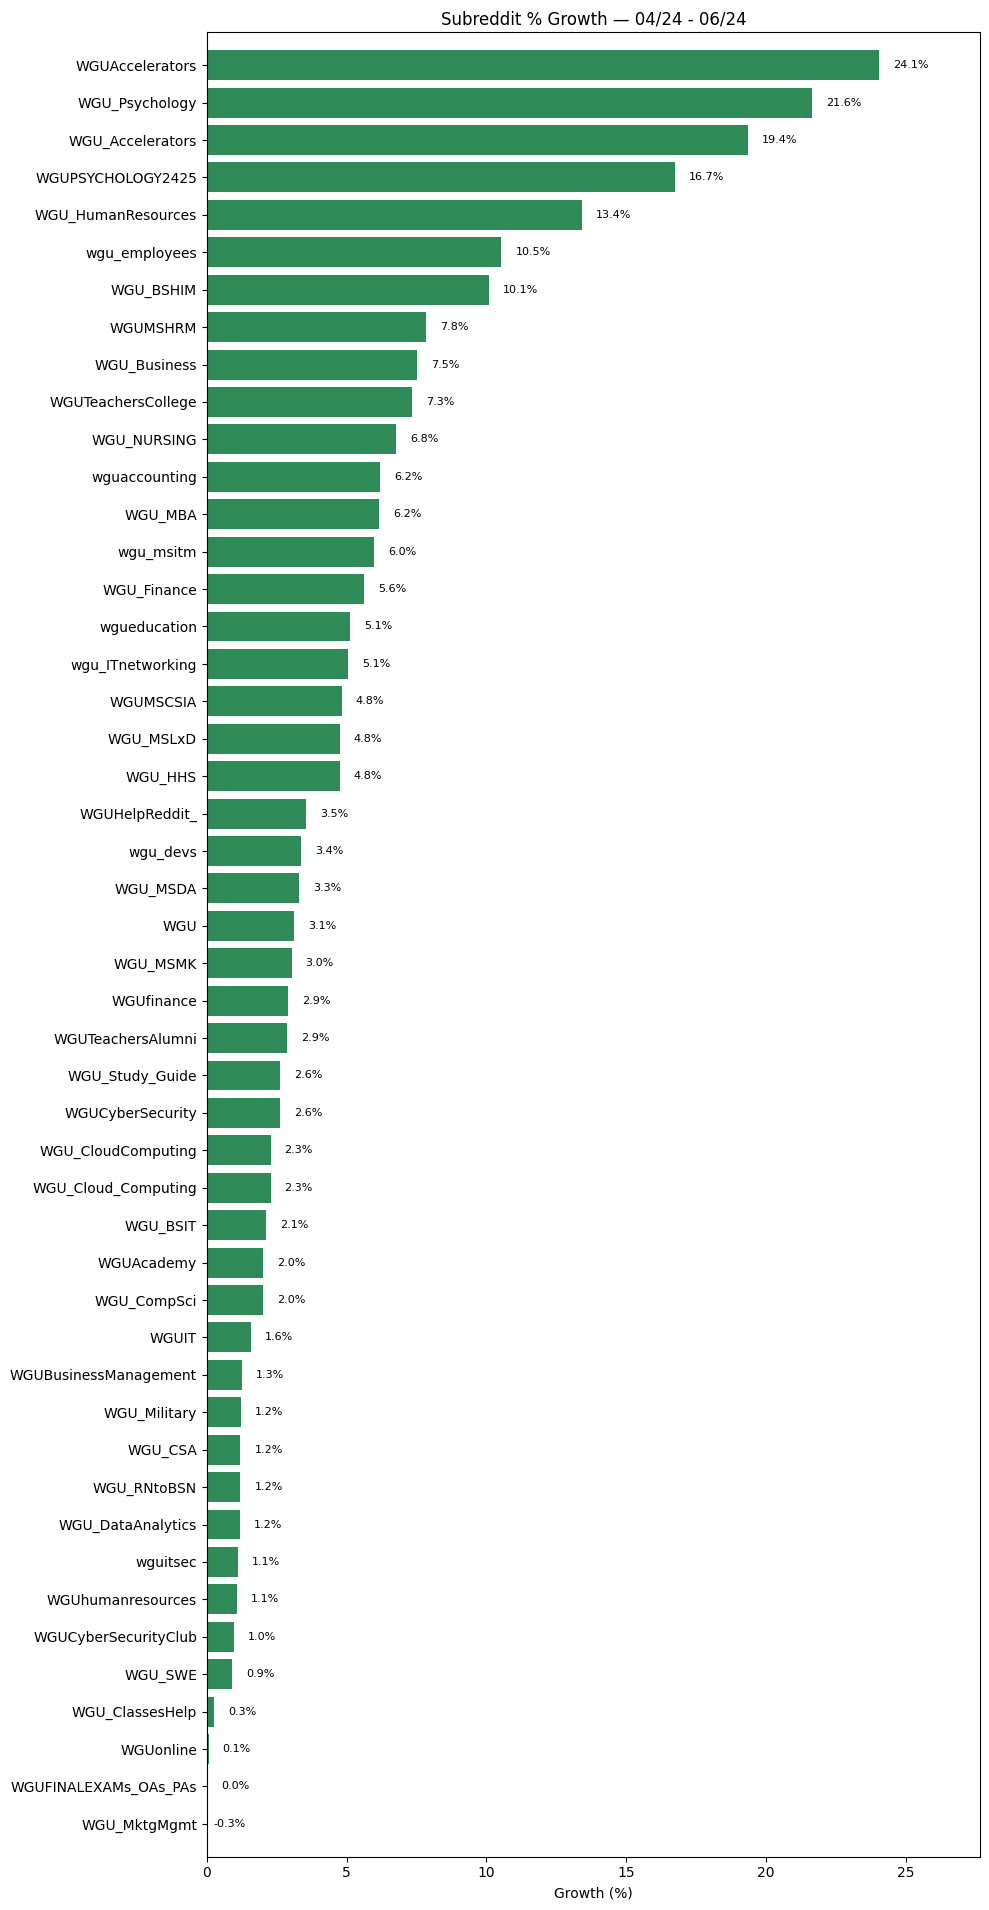

In [3]:
import matplotlib.pyplot as plt

# Filter for subreddits with a reasonable minimum base (e.g., >50 subscribers to avoid noise)
df_growth_filtered = df_growth[df_growth['subs_last'] > 50].sort_values('percent_change', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 0.4 * len(df_growth_filtered)))

bars = ax.barh(df_growth_filtered['name'], df_growth_filtered['percent_change'], color='seagreen')

# Annotate bars
for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(width + 0.5, y, f"{width:.1f}%", va='center', fontsize=8)

ax.set_xlabel("Growth (%)")
ax.set_title(f"Subreddit % Growth — {date_range_str}")
ax.margins(y=0.01)
ax.set_xlim(0, df_growth_filtered['percent_change'].max() * 1.15)
plt.tight_layout()
plt.show()